# TP1 TCP/IP

In this research exercice, we test the latency between nodes on different topologies, using the Mininet program.

## Mininet

The following code was run in a single script on the provided virtual machine. The data generated was stored on the shared folder.

In [ ]:
from mininet.net import Mininet
from mininet.node import Controller
from mininet.cli import CLI
from mininet.log import setLogLevel, info

## Star Topology

The star topology was proposed in the handout.
This function creates a network with N "edge" nodes with subnet 10.10.X.0/24 and IP 10.10.X.X. .
The "router" node is conneted to each other node, and has IP 10.10.X.N+1 on the subnet.

We perform 13 ping requests, and only keep the last 10 to account for extra communication which might occur when the ping is initiated (MAC address resolution for example).

In [1]:
def starNetwork(N):

    "Create an empty network and add nodes to it."
    net = Mininet()
    info('*** Adding controller\n')
    net.addController('c0')

    info('*** Adding hosts\n')

    router = net.addHost('PC0', ip='10.10.1.' + str(N + 1) + '/24')

    PCs = []
    switches = []
    links = []

    # create nodes
    for i in range(N):
        name = 'PC' + str(i + 1)
        address = '10.10.' + str(i + 1) + '.' + str(i + 1) + '/24'
        print(address)
        PCs.append(net.addHost(name, ip=address))

    # create switches and links
    for i in range(N):
        s = net.addSwitch('s' + str(i + 1) + '-' + str(N + 1))
        switches.append(s)
        links.append(net.addLink(PCs[i], s))
        links.append(net.addLink(router, s))

    # add router to all other subnets
    for i in range(1, N):
        router_dev =  'router-eth' + str(i)
        router.cmd('ip addr add  10.10.' + str(i + 1) + '.' + str(N + 1) +
                   '/24 dev ' + router_dev)

    router.cmd('echo 1 > /proc/sys/net/ipv4/ip_forward')
    info('*** Starting network\n')
    net.start()
    for i in range(N):
        PCs[i].cmd('ip route add default via 10.10.' + str(i + 1) + '.' +
                   str(N + 1))

    # Ping edge node to edge node
    PCs[0].cmd('ping ' + PCs[1].IP() + " -c 13 | sed -n '5,14 p '> " + PCs[0].name + '-' + PCs[1].name + '-'+ str(N) +'-star.txt')
    # Ping edge node to router node
    PCs[0].cmd('ping ' + router.IP() + " -c 13 | sed -n '5,14 p '> " + PCs[0].name + '-' + router.name + '-'+ str(N) +'-star.txt')

    info('*** Stopping network')
    net.stop()

## Chain Topology

Our next experiment was a "chain" with N nodes. 
Each node is connected to its predecessor and successor.
We index the nodes from 1 until N.
For each node i (except node N):
- IP 10.10.i.i on subnet 10.10.i.0/24
- IP 10.10.(i+1).i on subnet 10.10.(i+1).0/24

We set the default gateway to be the successor node (the last node routes to its predecessor).
We also add a static route for 10.10.1.0/24 since our pings will be performed from the first node.

We collect the following ping samples:
- if N = 100, we ping every 10th node on the chain, as well as the last one
- if N = 10, we ping all nodes

In [ ]:
def chainNetwork(N):

    "Create an empty network and add nodes to it."
    net = Mininet()
    info('*** Adding controller\n')
    net.addController('c0')

    info('*** Adding hosts\n')


    PCs = []
    switches = []
    links = []

    # create nodes
    PCs.append(net.addHost('PC1', ip='10.10.1.1/24'))
    for i in range(1,N):
        name = 'PC' + str(i + 1)
        address = '10.10.' + str(i) + '.' + str(i + 1) + '/24'
        print(address)
        PCs.append(net.addHost(name, ip=address))

    # create switches and links
    for i in range(N-1):
        s = net.addSwitch('s' + str(i + 1) + '-' + str(i + 2))
        switches.append(s)
        links.append(net.addLink(PCs[i+1], s))
        links.append(net.addLink(PCs[i], s))

    # add second interface to node [1,N-2] (intermediary node)
    for i in range(1, N-1):
        PCs[i].cmd('ip addr add  10.10.' + str(i+1)+ '.' + str(i+1) + '/24 dev ' + PCs[i].name +'-eth1')
        PCs[i].cmd('echo 1 > /proc/sys/net/ipv4/ip_forward')
        
    info('*** Starting network\n')
    net.start()

    #default gateway for node 0 and N-1
    PCs[0].cmd('ip route add default via 10.10.1.2 dev PC1-eth0')
    PCs[N-1].cmd('ip route add default via 10.10.' + str(N-1) + '.' + str(N-1) + ' dev ' + PCs[N-1].name +'-eth0')

    #default gateway for all other nodes
    for i in range(1,N-1):
        PCs[i].cmd('ip route add default via 10.10.' + str(i + 1) + '.' +
                   str(i + 2) + ' dev ' + PCs[i].name +'-eth1')

    #static route to PC1 for ping reply, from node 3 to N-1
    for i in range(2,N):
        PCs[i].cmd('ip route add 10.10.1.0/24 via 10.10.' + str(i) + '.' +
                   str(i) + ' dev ' + PCs[i].name +'-eth0')

    if N > 10:
        # ping every 10 nodes starting with 2
        for i in range(1, N,10):
            PCs[0].cmd('ping ' + PCs[i].IP() + " -c 13 | sed -n '5,14 p '> " + PCs[0].name + '-' + PCs[i].name + '-'+ str(N) +'-chain.txt')
        # ping last node
        PCs[0].cmd('ping ' + PCs[N-1].IP() + "-t 255 -c 13 | sed -n '5,14 p '> " + PCs[0].name + '-' + PCs[N-1].name + '-'+ str(N) +'-chain.txt')
    else:
        # ping all nodes
        for i in range(1, N):
            PCs[0].cmd('ping ' + PCs[i].IP() + " -c 13 | sed -n '5,14 p '> " + PCs[0].name + '-' + PCs[i].name + '-'+ str(N) +'-chain.txt')
            
    info('*** Stopping network')
    net.stop()

In [ ]:
chainNetwork(10)
chainNetwork(100)
starNetwork(5)
starNetwork(10)
starNetwork(50)
starNetwork(100)


### Loading data

This simple function reads all text files generated by the mininet scripts and stores them in a usable dataframe.

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
# This code is not aimed to be robust, and produces the right results, so we can ignore some warnings.
pd.options.mode.chained_assignment = None 

In [2]:
def load_pings():
    df = pd.DataFrame(columns=['time','source', 'dest', 'N', 'topo'])

    files = [f for f in os.listdir('./') if f.endswith('.txt')]
    for file in files:
        pc1, pc2, N, topo, _ = file.replace('.', '-').split('-')
        df2 = pd.read_csv(file, header=None)
        df2['source'] = pc1[2:]
        df2['dest'] = pc2[2:]
        df2['N'] = int(N)
        df2['topo'] = topo
        df2.columns = ['time', 'source','dest', 'N', 'topo']
        df2['time'] = df2['time'].apply(lambda x: x.split('time=')[1])
        df2['time'] = pd.to_timedelta(df2['time'])
        df2['time'] = df2['time'].apply(lambda x : x.microseconds)
        df = df.append(df2)
    df['time'] = pd.to_numeric(df['time'])
    df['source'] = pd.to_numeric(df['source'])
    df['dest'] = pd.to_numeric(df['dest'])
    df['N'] = pd.to_numeric(df['N'])
    return df
df = load_pings()
df

,time,source,dest,N,topo
0,52,1,0,100,star
1,156,1,0,100,star
2,43,1,0,100,star
3,70,1,0,100,star
4,51,1,0,100,star
...,...,...,...,...,...
5,209,1,12,100,chain
6,132,1,12,100,chain
7,148,1,12,100,chain
8,105,1,12,100,chain


## Plots

For each test, we measured 13 ping requests and removed the first 3 to get a better average behaviour (the first might provoke a MAC address resolution).

We noticed that round trip time (RTT) has quite a large variance, motivating the use of boxplots which give a bigger picture.

### Plotting the chain topology

We only one chain network with 100 nodes in order to test the latency between the first node, and various other ones after it.

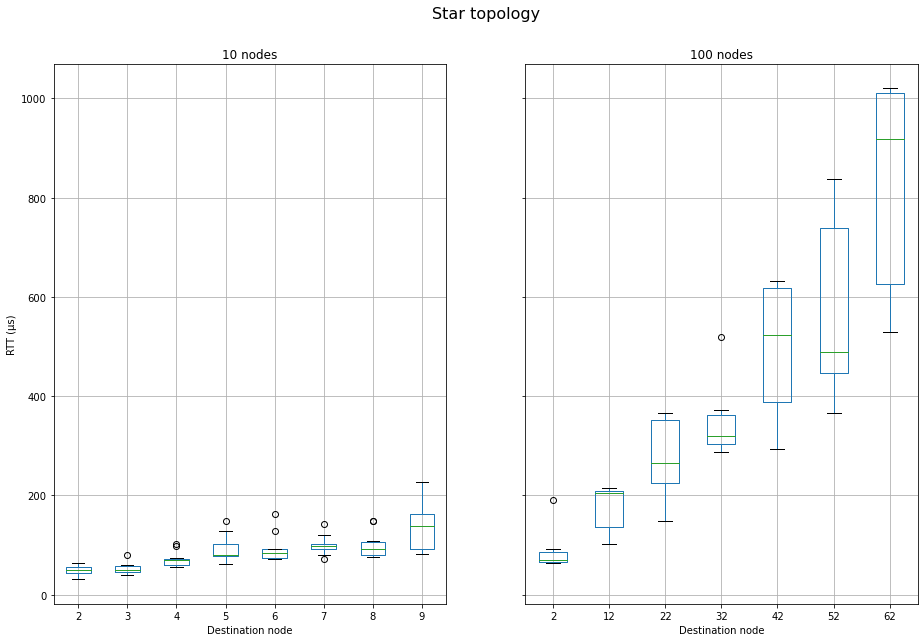

In [3]:
chain_df = df.loc[df["topo"] == "chain"]
chain_100_df = chain_df.loc[chain_df["N"] == 100]
chain_10_df = chain_df.loc[chain_df["N"] == 10]

fig, axes = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)
chain_10_df.boxplot(by='dest', column='time', return_type='axes', ax=axes[0])
axes[0].set_xlabel("Destination node")
axes[0].set_title("10 nodes")
axes[0].set_ylabel("RTT (µs)")
chain_100_df.boxplot(by='dest', column='time', return_type='axes', ax=axes[1])
axes[1].set_xlabel("Destination node")
axes[1].set_title("100 nodes")
fig.suptitle("Chain topology", fontsize=16)
plt.show()

As expected, the time required to ping time increases linearly with the distance, since the request must go through more intermediary nodes.

We do notice that as the distance grows, the variance in RTT grows as well. 
This is normal though, since there is a natural variance of the latency for each host,
and when going through multiple hosts, all individual latency are summed.

### Plotting the star topology

In this test, we measured the time required for a ping between:
- two edge nodes
- an edge node the router

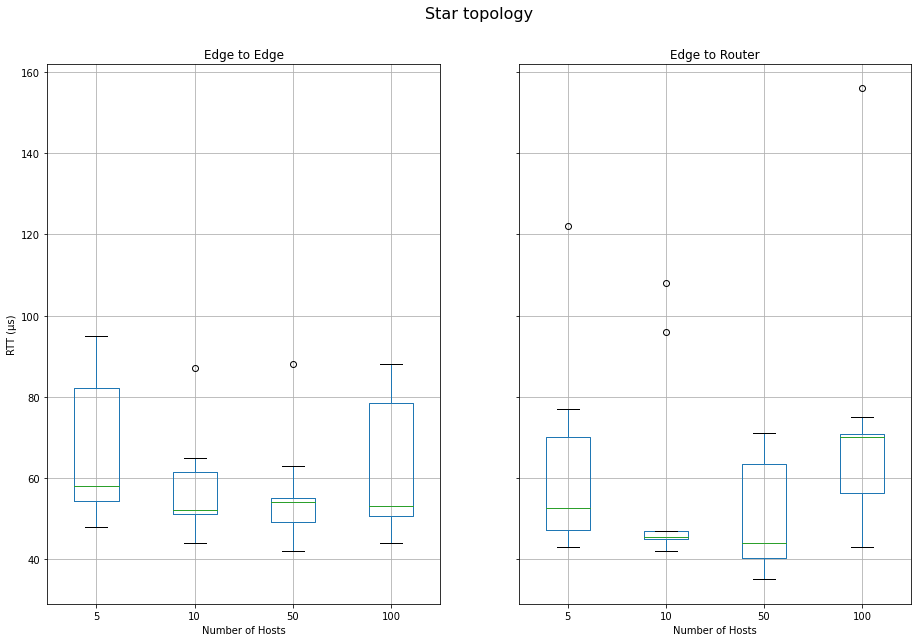

In [4]:
star_df = df.loc[df["topo"] == "star"]
edge2router = star_df.loc[star_df["dest"] == 0]
edge2edge = star_df.loc[star_df ["dest"] == 2]

fig, axes = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)
edge2edge.boxplot(by='N', column='time', return_type='axes', ax=axes[0])
axes[0].set_xlabel("Number of Hosts")
axes[0].set_title("Edge to Edge")
axes[0].set_ylabel("RTT (µs)")
edge2router.boxplot(by='N', column='time', return_type='axes', ax=axes[1])
axes[1].set_xlabel("Number of Hosts")
axes[1].set_title("Edge to Router")
fig.suptitle("Star topology", fontsize=16)
plt.show()

In the edge to router case, the mean RTT stays rather similar when the number of nodes increases.
For edge to edge communication, some large outliers are present, indicating that perhaps that the router takes more time to route certain packets.

With the current data, it would seem that the number of nodes does not have that much of an effect on RTT, but more ping data would be required to confirm this hypothesis.